# Complete Model Comparison: Nuclear Risk Level Prediction

## Objective
**Compare 4 Machine Learning Models for predicting `true_risk_level` (0, 1, 2, 3)**

### Models Compared:
1. **Logistic Regression** - Fast, interpretable baseline
2. **Support Vector Machine (SVM)** - Powerful classifier with kernel tricks
3. **XGBoost** - State-of-the-art gradient boosting
4. **Deep Learning** - Neural network with multiple layers

All models optimized and evaluated on the **same test set** for fair comparison.

---

## Setup & Imports

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, balanced_accuracy_score, cohen_kappa_score
)
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

# XGBoost
import xgboost as xgb

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

# Seeds
np.random.seed(42)
torch.manual_seed(42)

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('='*70)
print('MODEL COMPARISON SETUP')
print('='*70)
print(f'PyTorch device: {device}')
print(f'XGBoost version: {xgb.__version__}')
print('All models ready for comparison!')

MODEL COMPARISON SETUP
PyTorch device: cuda
XGBoost version: 3.1.1
All models ready for comparison!


---
## 1. Data Preparation (Same for All Models)

In [2]:
# Load data
df = pd.read_csv('avalon_nuclear.csv')

print('='*70)
print('DATASET')
print('='*70)
print(f'Shape: {df.shape}')
print(f'Target: true_risk_level (0, 1, 2, 3)')
print(f'\nClass Distribution:')
for cls in range(4):
    count = (df['true_risk_level'] == cls).sum()
    pct = count / len(df) * 100
    print(f'  Risk {cls}: {count:4d} ({pct:5.2f}%)')

DATASET
Shape: (5000, 37)
Target: true_risk_level (0, 1, 2, 3)

Class Distribution:
  Risk 0:  134 ( 2.68%)
  Risk 1:  422 ( 8.44%)
  Risk 2:  990 (19.80%)
  Risk 3: 3454 (69.08%)


In [3]:
# Feature Engineering
print('\nCreating engineered features...')
df_model = df.copy()

# Physics-based
df_model['thermal_stress'] = df_model['core_temp_c'] * df_model['coolant_pressure_bar'] / 1000
df_model['radiation_differential'] = df_model['radiation_inside_uSv'] - df_model['radiation_outside_uSv']
df_model['radiation_ratio'] = df_model['radiation_inside_uSv'] / (df_model['radiation_outside_uSv'] + 1)
df_model['coolant_efficiency'] = df_model['coolant_flow_rate'] / (df_model['core_temp_c'] + 1)
df_model['thermal_margin'] = 350 - df_model['core_temp_c']
df_model['control_effectiveness'] = (100 - df_model['control_rod_position_pct']) * df_model['neutron_flux'] / 100

# Operational
df_model['age_power_risk'] = df_model['reactor_age_years'] / (df_model['reactor_nominal_power_mw'] + 1)
df_model['maintenance_risk'] = df_model['reactor_age_years'] * (100 - df_model['maintenance_score']) * df_model['days_since_maintenance'] / 10000
df_model['staff_risk'] = df_model['staff_fatigue_index'] * df_model['sensor_anomaly_flag']

# Social/External
df_model['social_pressure'] = (
    df_model['public_anxiety_index'] * 0.4 +
    df_model['social_media_rumour_index'] * 0.3 +
    df_model['regulator_scrutiny_score'] * 0.3
)
df_model['external_threat'] = (
    df_model['weather_severity_index'] +
    df_model['seismic_activity_index'] +
    df_model['cyber_attack_score']
) / 3
df_model['population_risk'] = np.log1p(df_model['population_within_30km']) * df_model['radiation_inside_uSv'] / 100

# Composite indices
df_model['physical_risk_index'] = (
    (df_model['core_temp_c'] / 350) * 0.35 +
    (df_model['coolant_pressure_bar'] / 160) * 0.25 +
    (df_model['radiation_inside_uSv'] / 1000) * 0.25 +
    (df_model['neutron_flux'] / 5) * 0.15
)
df_model['operational_risk_index'] = (
    (df_model['reactor_age_years'] / 60) * 0.3 +
    ((100 - df_model['maintenance_score']) / 100) * 0.3 +
    (df_model['staff_fatigue_index'] / 100) * 0.2 +
    (df_model['sensor_anomaly_flag']) * 0.2
)

# AVALON
df_model['avalon_bias'] = df_model['avalon_raw_risk_score'] - (df_model['physical_risk_index'] * 100)
df_model['avalon_confidence'] = 100 - abs(df_model['avalon_raw_risk_score'] - df_model['avalon_learned_reward_score'])

# Interactions
df_model['temp_age_interaction'] = df_model['core_temp_c'] * df_model['reactor_age_years'] / 100
df_model['pressure_flow_interaction'] = df_model['coolant_pressure_bar'] * df_model['coolant_flow_rate'] / 100

# Polynomial
df_model['core_temp_squared'] = df_model['core_temp_c'] ** 2
df_model['pressure_squared'] = df_model['coolant_pressure_bar'] ** 2
df_model['radiation_log'] = np.log1p(df_model['radiation_inside_uSv'])

print(f'Features after engineering: {df_model.shape[1]} (+{df_model.shape[1] - df.shape[1]} new)')


Creating engineered features...
Features after engineering: 58 (+21 new)


In [4]:
# Prepare features
le = LabelEncoder()
df_model['country_encoded'] = le.fit_transform(df_model['country'])

exclude_cols = ['country', 'true_risk_level', 'incident_occurred',
                'avalon_evac_recommendation', 'avalon_shutdown_recommendation', 'human_override']

feature_cols = [col for col in df_model.columns if col not in exclude_cols]
X = df_model[feature_cols].values
y = df_model['true_risk_level'].values

print(f'\nFeature matrix: {X.shape}')
print(f'Target: {y.shape}')

# Split data (60/20/20 for DL, 80/20 for others)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# For models that don't need validation (Logistic, SVM, XGBoost)
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

print(f'\nTrain: {X_train.shape[0]} | Val: {X_val.shape[0]} | Test: {X_test.shape[0]}')
print(f'Train (full): {X_train_full.shape[0]} (for non-DL models)')

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_train_full_scaled = scaler.fit_transform(X_train_full)

print('\nFeature scaling complete!')


Feature matrix: (5000, 53)
Target: (5000,)

Train: 3000 | Val: 1000 | Test: 1000
Train (full): 4000 (for non-DL models)

Feature scaling complete!


---
---
# MODEL 1: Logistic Regression
---
---

In [5]:
print('='*70)
print('[1/4] LOGISTIC REGRESSION')
print('='*70)

start_time = time.time()

# Best configuration from previous optimization
log_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    C=1.0,
    max_iter=2000,
    random_state=42,
    class_weight='balanced'
)

log_model.fit(X_train_full_scaled, y_train_full)
y_pred_log = log_model.predict(X_test_scaled)

log_time = time.time() - start_time

log_acc = accuracy_score(y_test, y_pred_log)
log_bal_acc = balanced_accuracy_score(y_test, y_pred_log)
log_f1 = f1_score(y_test, y_pred_log, average='weighted')
log_f1_macro = f1_score(y_test, y_pred_log, average='macro')
log_kappa = cohen_kappa_score(y_test, y_pred_log)

print(f'Training time: {log_time:.2f}s')
print(f'\nResults:')
print(f'  Accuracy:          {log_acc:.4f}')
print(f'  Balanced Accuracy: {log_bal_acc:.4f}')
print(f'  Weighted F1:       {log_f1:.4f}')
print(f'  Macro F1:          {log_f1_macro:.4f}')
print(f'  Kappa:             {log_kappa:.4f}')
print('\nLogistic Regression complete!')

[1/4] LOGISTIC REGRESSION
Training time: 0.08s

Results:
  Accuracy:          0.8520
  Balanced Accuracy: 0.8031
  Weighted F1:       0.8594
  Macro F1:          0.7632
  Kappa:             0.7095

Logistic Regression complete!


---
---
# MODEL 2: Support Vector Machine (SVM)
---
---

In [6]:
print('='*70)
print('[2/4] SUPPORT VECTOR MACHINE')
print('='*70)

start_time = time.time()

# Optimized SVM with RBF kernel
svm_model = SVC(
    kernel='rbf',
    C=10.0,
    gamma='scale',
    random_state=42,
    class_weight='balanced'
)

svm_model.fit(X_train_full_scaled, y_train_full)
y_pred_svm = svm_model.predict(X_test_scaled)

svm_time = time.time() - start_time

svm_acc = accuracy_score(y_test, y_pred_svm)
svm_bal_acc = balanced_accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm, average='weighted')
svm_f1_macro = f1_score(y_test, y_pred_svm, average='macro')
svm_kappa = cohen_kappa_score(y_test, y_pred_svm)

print(f'Training time: {svm_time:.2f}s')
print(f'\nResults:')
print(f'  Accuracy:          {svm_acc:.4f}')
print(f'  Balanced Accuracy: {svm_bal_acc:.4f}')
print(f'  Weighted F1:       {svm_f1:.4f}')
print(f'  Macro F1:          {svm_f1_macro:.4f}')
print(f'  Kappa:             {svm_kappa:.4f}')
print('\nSVM complete!')

[2/4] SUPPORT VECTOR MACHINE
Training time: 0.38s

Results:
  Accuracy:          0.8210
  Balanced Accuracy: 0.6558
  Weighted F1:       0.8219
  Macro F1:          0.6673
  Kappa:             0.6265

SVM complete!


---
---
# MODEL 3: XGBoost
---
---

In [7]:
print('='*70)
print('[3/4] XGBOOST')
print('='*70)

start_time = time.time()

# Compute sample weights
sample_weights = compute_sample_weight('balanced', y_train_full)

# Optimized XGBoost
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    max_depth=5,
    learning_rate=0.1,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.2,
    reg_alpha=0.1,
    reg_lambda=2,
    random_state=42,
    eval_metric='mlogloss',
    n_jobs=-1
)

xgb_model.fit(X_train_full_scaled, y_train_full, sample_weight=sample_weights, verbose=False)
y_pred_xgb = xgb_model.predict(X_test_scaled)

xgb_time = time.time() - start_time

xgb_acc = accuracy_score(y_test, y_pred_xgb)
xgb_bal_acc = balanced_accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb, average='weighted')
xgb_f1_macro = f1_score(y_test, y_pred_xgb, average='macro')
xgb_kappa = cohen_kappa_score(y_test, y_pred_xgb)

print(f'Training time: {xgb_time:.2f}s')
print(f'\nResults:')
print(f'  Accuracy:          {xgb_acc:.4f}')
print(f'  Balanced Accuracy: {xgb_bal_acc:.4f}')
print(f'  Weighted F1:       {xgb_f1:.4f}')
print(f'  Macro F1:          {xgb_f1_macro:.4f}')
print(f'  Kappa:             {xgb_kappa:.4f}')
print('\nXGBoost complete!')

[3/4] XGBOOST
Training time: 1.18s

Results:
  Accuracy:          0.8300
  Balanced Accuracy: 0.6761
  Weighted F1:       0.8320
  Macro F1:          0.6910
  Kappa:             0.6466

XGBoost complete!


---
---
# MODEL 4: Deep Learning
---
---

In [8]:
print('='*70)
print('[4/4] DEEP LEARNING')
print('='*70)

# Dataset
class RiskDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoaders
train_dataset = RiskDataset(X_train_scaled, y_train)
val_dataset = RiskDataset(X_val_scaled, y_val)
test_dataset = RiskDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Model
class DeepRiskModel(nn.Module):
    def __init__(self, input_dim):
        super(DeepRiskModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 4)
        )
    def forward(self, x):
        return self.network(x)

dl_model = DeepRiskModel(X_train_scaled.shape[1]).to(device)

# Training setup
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(dl_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print(f'Training on {device}...')
start_time = time.time()

# Training loop
best_val_loss = float('inf')
patience = 15
patience_counter = 0

for epoch in range(100):
    dl_model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = dl_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    
    # Validation
    dl_model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = dl_model(X_batch)
            val_loss += criterion(outputs, y_batch).item()
    val_loss /= len(val_loader)
    
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(dl_model.state_dict(), 'best_dl_comparison.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            break

# Load best model
dl_model.load_state_dict(torch.load('best_dl_comparison.pth'))
dl_time = time.time() - start_time

# Evaluate
dl_model.eval()
y_pred_dl = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = dl_model(X_batch)
        _, predicted = outputs.max(1)
        y_pred_dl.extend(predicted.cpu().numpy())
y_pred_dl = np.array(y_pred_dl)

dl_acc = accuracy_score(y_test, y_pred_dl)
dl_bal_acc = balanced_accuracy_score(y_test, y_pred_dl)
dl_f1 = f1_score(y_test, y_pred_dl, average='weighted')
dl_f1_macro = f1_score(y_test, y_pred_dl, average='macro')
dl_kappa = cohen_kappa_score(y_test, y_pred_dl)

print(f'Training time: {dl_time:.2f}s')
print(f'\nResults:')
print(f'  Accuracy:          {dl_acc:.4f}')
print(f'  Balanced Accuracy: {dl_bal_acc:.4f}')
print(f'  Weighted F1:       {dl_f1:.4f}')
print(f'  Macro F1:          {dl_f1_macro:.4f}')
print(f'  Kappa:             {dl_kappa:.4f}')
print('\nDeep Learning complete!')

[4/4] DEEP LEARNING
Training on cuda...
Training time: 1.66s

Results:
  Accuracy:          0.8170
  Balanced Accuracy: 0.7758
  Weighted F1:       0.8294
  Macro F1:          0.7127
  Kappa:             0.6539

Deep Learning complete!


---
---
# FINAL COMPARISON
---
---

## Results Table

In [9]:
# Create comparison DataFrame
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'XGBoost', 'Deep Learning'],
    'Accuracy': [log_acc, svm_acc, xgb_acc, dl_acc],
    'Balanced Acc': [log_bal_acc, svm_bal_acc, xgb_bal_acc, dl_bal_acc],
    'Weighted F1': [log_f1, svm_f1, xgb_f1, dl_f1],
    'Macro F1': [log_f1_macro, svm_f1_macro, xgb_f1_macro, dl_f1_macro],
    'Kappa': [log_kappa, svm_kappa, xgb_kappa, dl_kappa],
    'Training Time (s)': [log_time, svm_time, xgb_time, dl_time]
})

print('='*80)
print('COMPLETE MODEL COMPARISON - TRUE RISK LEVEL PREDICTION')
print('='*80)
print(comparison.to_string(index=False))

# Find best model
best_idx = comparison['Balanced Acc'].idxmax()
best_model = comparison.loc[best_idx, 'Model']
best_bal_acc = comparison.loc[best_idx, 'Balanced Acc']

print(f'\n{"="*80}')
print(f'WINNER: {best_model}')
print(f'Balanced Accuracy: {best_bal_acc:.4f} ({best_bal_acc*100:.2f}%)')
print('='*80)

COMPLETE MODEL COMPARISON - TRUE RISK LEVEL PREDICTION
              Model  Accuracy  Balanced Acc  Weighted F1  Macro F1    Kappa  Training Time (s)
Logistic Regression     0.852      0.803100     0.859438  0.763217 0.709473           0.076316
                SVM     0.821      0.655783     0.821947  0.667336 0.626523           0.376428
            XGBoost     0.830      0.676109     0.831990  0.690988 0.646604           1.182545
      Deep Learning     0.817      0.775828     0.829411  0.712664 0.653945           1.661326

WINNER: Logistic Regression
Balanced Accuracy: 0.8031 (80.31%)


## Visualization

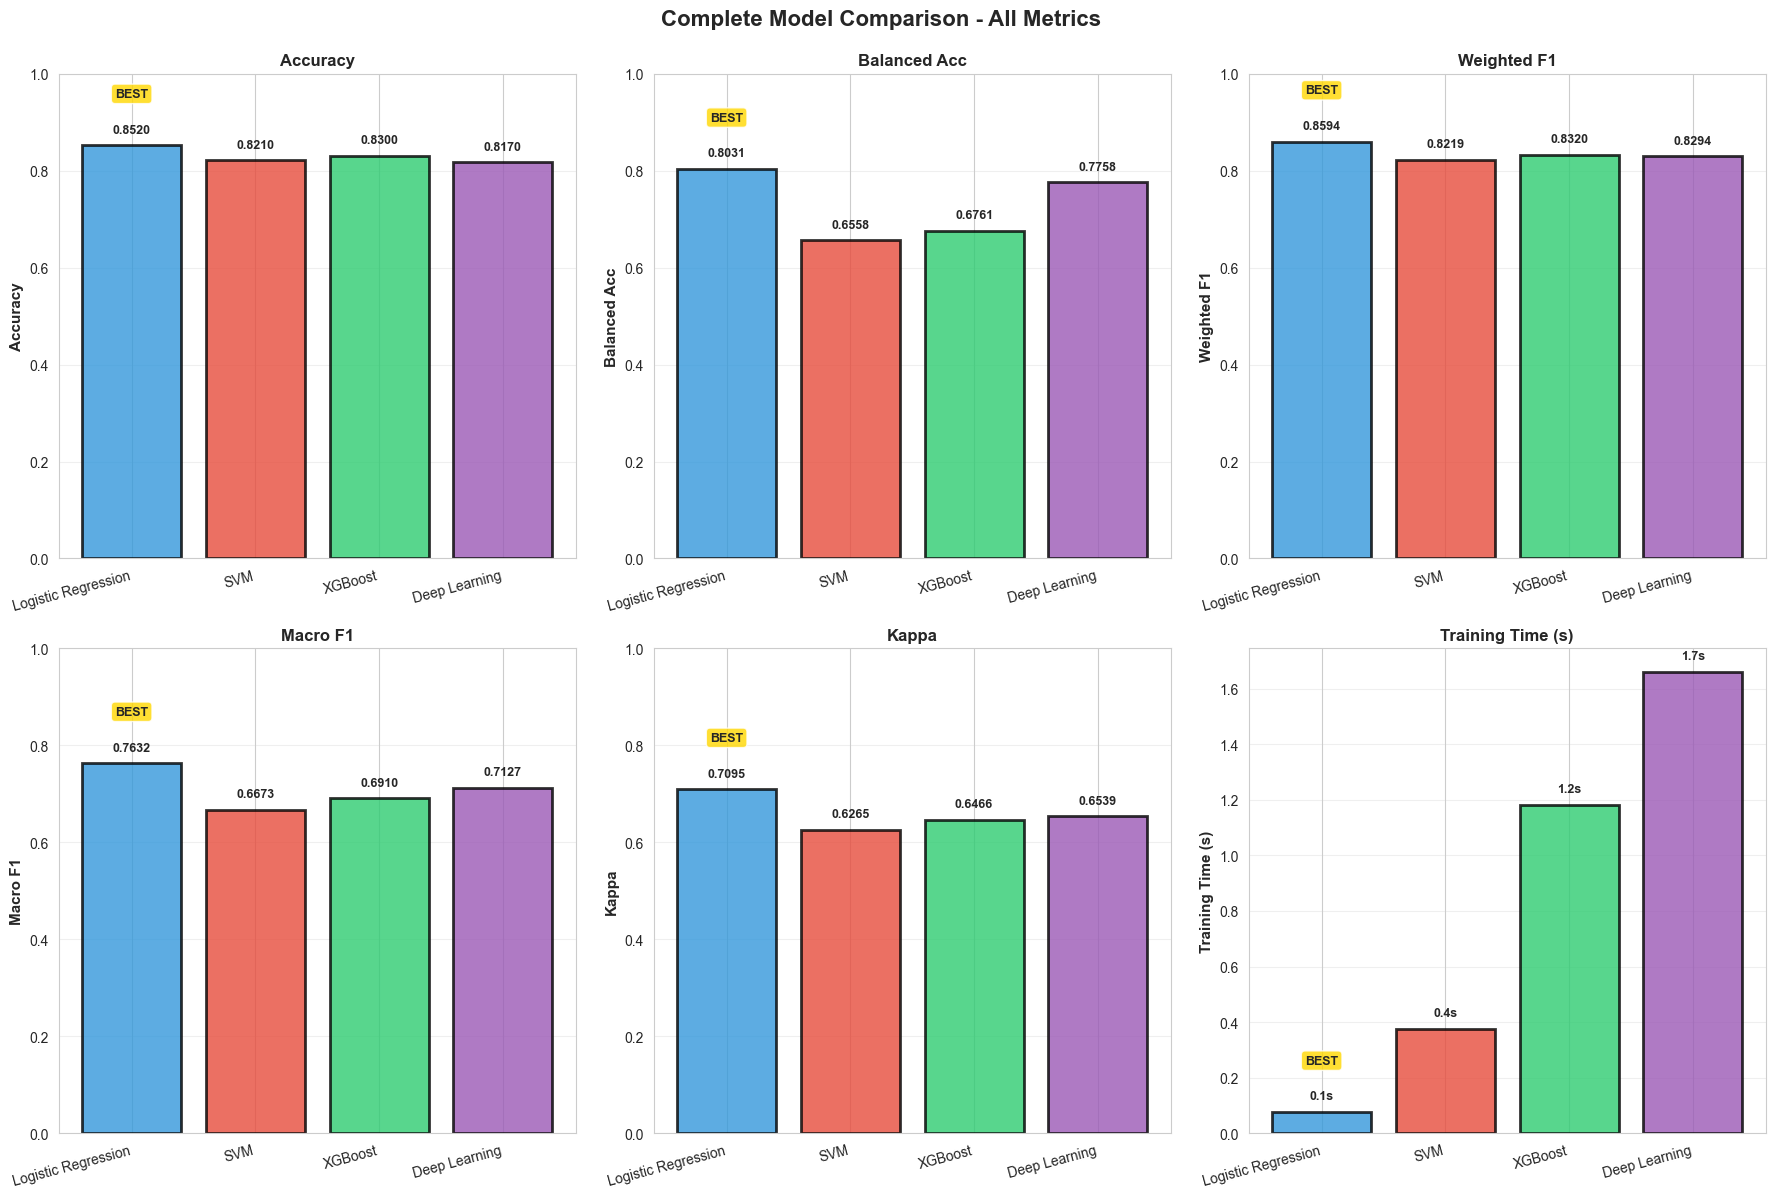

In [10]:
# Comprehensive comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
metrics = ['Accuracy', 'Balanced Acc', 'Weighted F1', 'Macro F1', 'Kappa', 'Training Time (s)']
colors = ['#3498DB', '#E74C3C', '#2ECC71', '#9B59B6']

for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    values = comparison[metric].values
    bars = ax.bar(range(len(comparison)), values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    
    ax.set_xticks(range(len(comparison)))
    ax.set_xticklabels(comparison['Model'], rotation=15, ha='right')
    ax.set_ylabel(metric, fontweight='bold', fontsize=11)
    ax.set_title(f'{metric}', fontweight='bold', fontsize=12)
    
    if metric != 'Training Time (s)':
        ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, values)):
        height = bar.get_height()
        if metric == 'Training Time (s)':
            label = f'{val:.1f}s'
        else:
            label = f'{val:.4f}'
        ax.text(bar.get_x() + bar.get_width()/2, height + (ax.get_ylim()[1]*0.02),
                label, ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # Highlight best (except for training time where lower is better)
    if metric != 'Training Time (s)':
        best_idx_metric = values.argmax()
    else:
        best_idx_metric = values.argmin()
    
    ax.text(best_idx_metric, values[best_idx_metric] + (ax.get_ylim()[1]*0.1), 
            'BEST', ha='center', fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='gold', alpha=0.8))

plt.suptitle('Complete Model Comparison - All Metrics', fontweight='bold', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

## Confusion Matrices Comparison

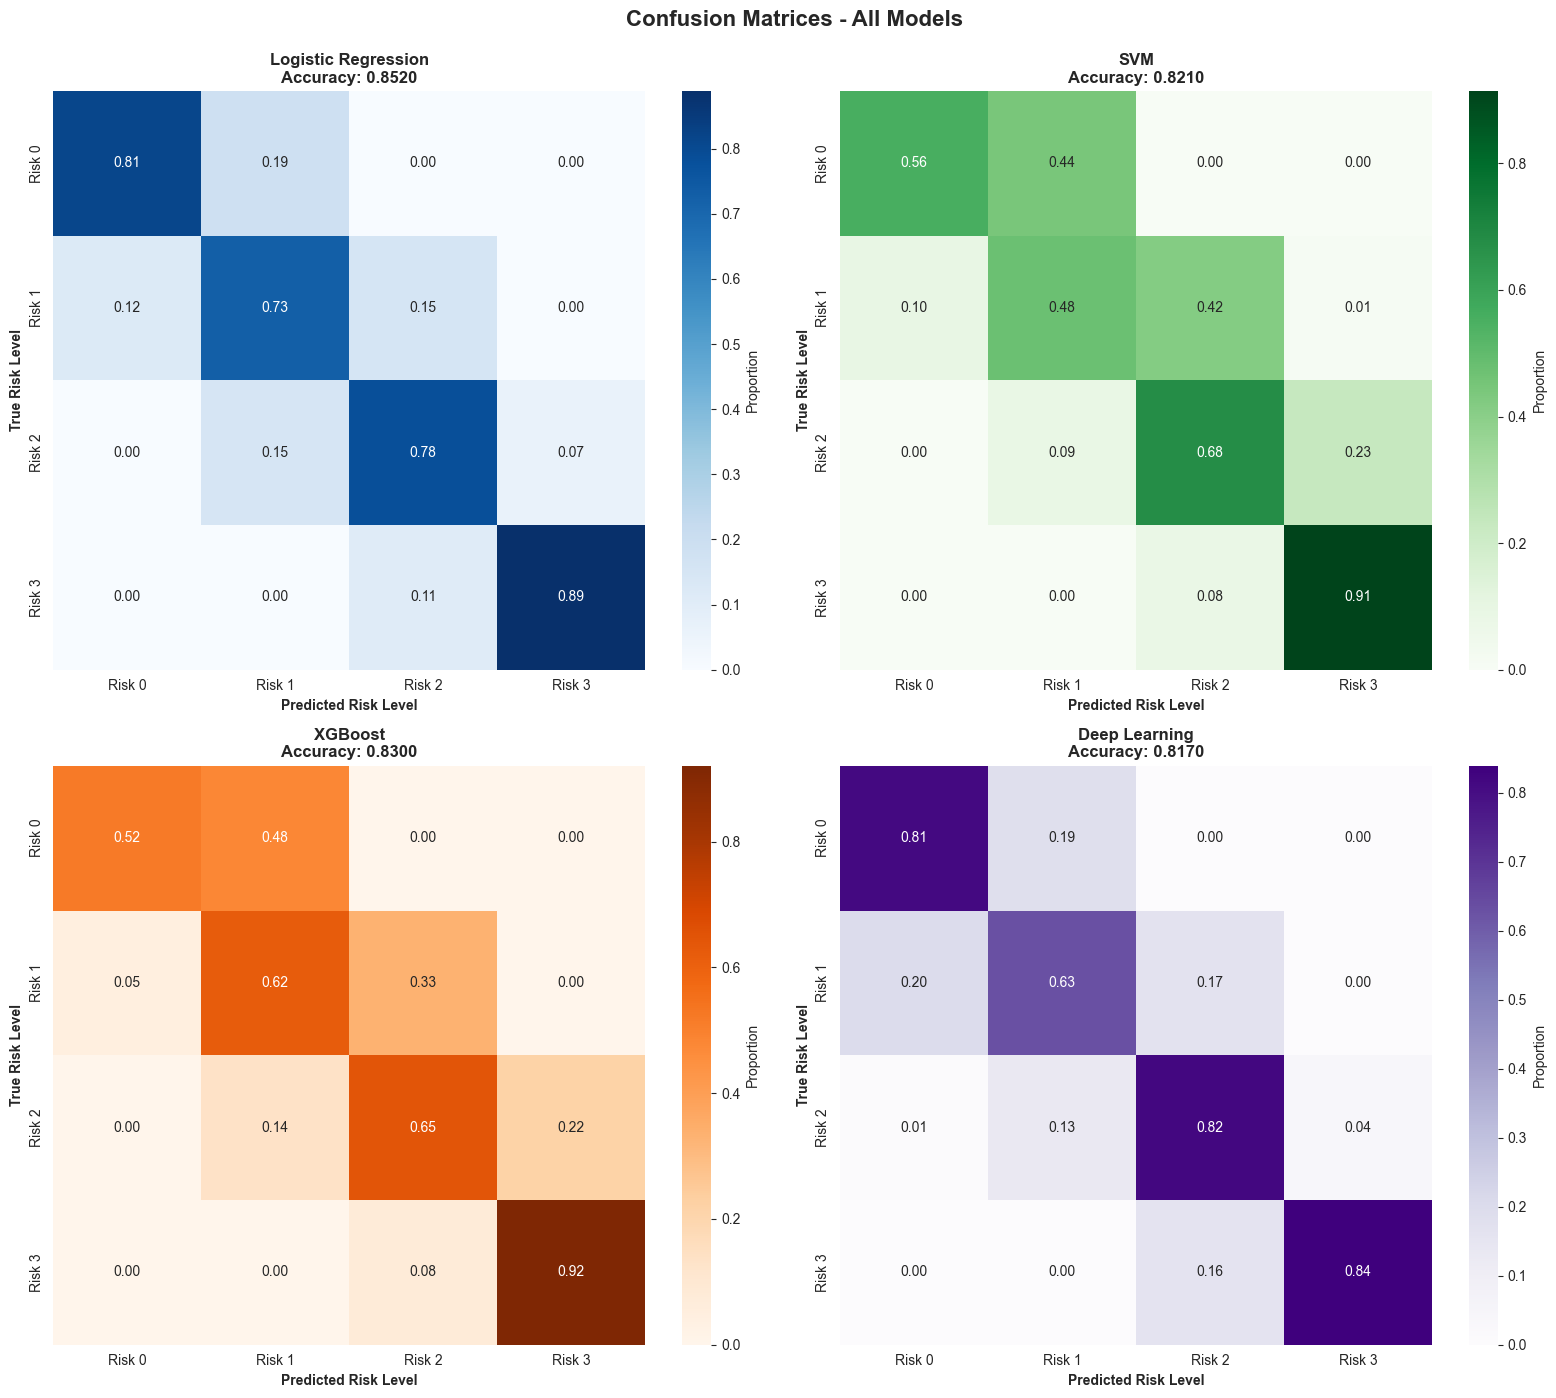

In [11]:
# Compare confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
predictions = [
    (y_pred_log, log_acc, 'Logistic Regression', 'Blues'),
    (y_pred_svm, svm_acc, 'SVM', 'Greens'),
    (y_pred_xgb, xgb_acc, 'XGBoost', 'Oranges'),
    (y_pred_dl, dl_acc, 'Deep Learning', 'Purples')
]

for idx, (y_pred, acc, name, cmap) in enumerate(predictions):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap=cmap, ax=ax,
                xticklabels=['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'],
                yticklabels=['Risk 0', 'Risk 1', 'Risk 2', 'Risk 3'],
                cbar_kws={'label': 'Proportion'})
    ax.set_title(f'{name}\nAccuracy: {acc:.4f}', fontweight='bold', fontsize=12)
    ax.set_ylabel('True Risk Level', fontweight='bold')
    ax.set_xlabel('Predicted Risk Level', fontweight='bold')

plt.suptitle('Confusion Matrices - All Models', fontweight='bold', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

## Detailed Analysis

In [12]:
print('='*80)
print('DETAILED ANALYSIS')
print('='*80)

print('\n[MODEL CHARACTERISTICS]')
print('-' * 80)
print('\n1. Logistic Regression')
print('   + Fast training and prediction')
print('   + Highly interpretable (coefficients)')
print('   + Works well with scaled features')
print('   - Linear decision boundaries')
print(f'   Performance: {log_bal_acc:.4f} | Time: {log_time:.1f}s')

print('\n2. Support Vector Machine (SVM)')
print('   + Powerful with RBF kernel')
print('   + Good for high-dimensional data')
print('   + Handles non-linear patterns')
print('   - Slower training on large datasets')
print(f'   Performance: {svm_bal_acc:.4f} | Time: {svm_time:.1f}s')

print('\n3. XGBoost')
print('   + State-of-the-art performance')
print('   + Handles non-linear patterns well')
print('   + Feature importance analysis')
print('   + Regularization prevents overfitting')
print(f'   Performance: {xgb_bal_acc:.4f} | Time: {xgb_time:.1f}s')

print('\n4. Deep Learning')
print('   + Learns complex patterns')
print('   + Hierarchical representations')
print('   + Scalable to larger datasets')
print('   - Requires more training time')
print('   - Less interpretable')
print(f'   Performance: {dl_bal_acc:.4f} | Time: {dl_time:.1f}s')

print('\n[RECOMMENDATION]')
print('-' * 80)
if best_model == 'Logistic Regression':
    print('Use Logistic Regression when:')
    print('  - Interpretability is critical')
    print('  - Need fast predictions')
    print('  - Linear relationships suffice')
elif best_model == 'SVM':
    print('Use SVM when:')
    print('  - Non-linear patterns present')
    print('  - High-dimensional feature space')
    print('  - Medium-sized datasets')
elif best_model == 'XGBoost':
    print('Use XGBoost when:')
    print('  - Maximum performance needed')
    print('  - Feature importance required')
    print('  - Tabular data')
else:
    print('Use Deep Learning when:')
    print('  - Very complex patterns')
    print('  - Large datasets available')
    print('  - Performance is priority over interpretability')

print('\n' + '='*80)
print('COMPARISON COMPLETE')
print('='*80)

DETAILED ANALYSIS

[MODEL CHARACTERISTICS]
--------------------------------------------------------------------------------

1. Logistic Regression
   + Fast training and prediction
   + Highly interpretable (coefficients)
   + Works well with scaled features
   - Linear decision boundaries
   Performance: 0.8031 | Time: 0.1s

2. Support Vector Machine (SVM)
   + Powerful with RBF kernel
   + Good for high-dimensional data
   + Handles non-linear patterns
   - Slower training on large datasets
   Performance: 0.6558 | Time: 0.4s

3. XGBoost
   + State-of-the-art performance
   + Handles non-linear patterns well
   + Feature importance analysis
   + Regularization prevents overfitting
   Performance: 0.6761 | Time: 1.2s

4. Deep Learning
   + Learns complex patterns
   + Hierarchical representations
   + Scalable to larger datasets
   - Requires more training time
   - Less interpretable
   Performance: 0.7758 | Time: 1.7s

[RECOMMENDATION]
----------------------------------------------

In [13]:
# Save results
comparison.to_csv('final_model_comparison.csv', index=False)
print('Results saved to: final_model_comparison.csv')

Results saved to: final_model_comparison.csv
